# Building Multi-Task NLP model with LSTM : Detect Emotions, Hate Speech & Violence in Text

> Detect Emotion , violence , Hate Speech



## Dataset

(i) Emotion Data: https://www.kaggle.com/datasets/nelgiriyewithana/emotions

(ii) Violence Data: https://www.kaggle.com/datasets/gauravduttakiit/gender-based-violence-tweet-classification?select=Train.csv

(iii) Hate Speech Data: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset


**Emotions**

0 : Sadness

1 : Joy

2 : Love

3 : Anger

4 : Fear

5 : Surprise

**Violence**

0 : Harmful_Traditional_practice

1 : Physical_violence

2 : economic_violence

3 : emotional_violence

4 : sexual_violence

**Hate**

0 : Hate Speech

1 : Offensive Speech

2 : Neither


## 0.Setup


In [1]:
import pandas as pd
import numpy as np

# SK learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# NLP
import nltk
from nltk.corpus import stopwords

# DeepLearning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras


# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Unable to revert mtime: /Library/Fonts
Matplotlib is building the font cache; this may take a moment.


In [4]:
! mkdir ~/.kaggle
! cp ../kaggle-token.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle-token.json

mkdir: /Users/magesh/.kaggle: File exists


## Download Dataset

In [5]:
!kaggle datasets download -d nelgiriyewithana/emotions
!kaggle datasets download -d gauravduttakiit/gender-based-violence-tweet-classification
!kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset

100%|██████████████████████████████████████| 15.7M/15.7M [00:05<00:00, 3.28MB/s]
100%|██████████████████████████████████████| 15.7M/15.7M [00:05<00:00, 2.82MB/s]
 97%|████████████████████████████████████▋ | 5.00M/5.17M [00:02<00:00, 2.46MB/s]
100%|██████████████████████████████████████| 5.17M/5.17M [00:02<00:00, 1.97MB/s]
 99%|██████████████████████████████████████▊| 1.00M/1.01M [00:01<00:00, 776kB/s]
100%|███████████████████████████████████████| 1.01M/1.01M [00:01<00:00, 780kB/s]


In [7]:
import zipfile

# Create the 'data' directory if it doesn't exist
!mkdir -p data

def unzip_files(zip_filepath, extract_dir):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Unzip the files into the 'data' folder
unzip_files("../data/emotions.zip", "../data/")
unzip_files("../data/gender-based-violence-tweet-classification.zip", "../data/")
unzip_files("../data/hate-speech-and-offensive-language-dataset.zip", "../data/")


FileNotFoundError: [Errno 2] No such file or directory: './data/gender-based-violence-tweet-classification.zip'

## 1.Load Dataset

In [11]:
emotion_df=pd.read_csv("../data/text.csv")
violence_df=pd.read_csv("../data/Train.csv")
hate_df=pd.read_csv("../data/labeled_data.csv")

## 1. Data Cleaning (Common for All Datasets)


* Remove unwated columns

* Rename columns

* check for null values



In [12]:

def clean_dataset(emotion_df, violence_df, hate_df):
    """Cleans the datasets by removing unwanted columns.

    Args:
        emotion_df: Pandas DataFrame containing emotion data.
        violence_df: Pandas DataFrame containing violence data.
        hate_df: Pandas DataFrame containing hate speech data.

    Returns:
        A tuple containing the cleaned DataFrames: (emotion_df, violence_df, hate_df).
    """
    # remove unwanted columns
    emotion_df.drop(columns=["Unnamed: 0"], inplace=True)
    violence_df.drop(columns=["Tweet_ID"], inplace=True)
    new_hate_df = hate_df[["tweet", "class"]]  # pick only tweet and class

    # rename the column

    violence_df.rename(columns={"tweet":"text","type":"label"},inplace=True)
    new_hate_df.rename(columns={"tweet":"text","class":"label"},inplace=True)

    return emotion_df, violence_df, new_hate_df


# Clean the datasets
emotion_df, violence_df, hate_df = clean_dataset(emotion_df, violence_df, hate_df)

In [13]:
emotion_df.columns,violence_df.columns,hate_df.columns

(Index(['text', 'label'], dtype='object'),
 Index(['text', 'label'], dtype='object'),
 Index(['text', 'label'], dtype='object'))

### 2. Exploratory Data Analysis

* check for class distributions




In [14]:
emotion_df.isnull().sum(),violence_df.isnull().sum(),hate_df.isnull().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

In [15]:
emotion_df['label'].value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [16]:
violence_df['label'].value_counts()

label
sexual_violence                 32648
Physical_violence                5946
emotional_violence                651
economic_violence                 217
Harmful_Traditional_practice      188
Name: count, dtype: int64

In [17]:
hate_df['label'].value_counts()

label
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [18]:
import pandas as pd
import numpy as np

def balance_datasets(emotion_df, violence_df, hate_df):
    # Balance Emotion Data
    e_df = pd.DataFrame()
    for i in range(6):
        subset = emotion_df[emotion_df['label'] == i].sample(n=2000, random_state=42)
        e_df = pd.concat([e_df, subset])
    emotion_df = e_df.copy()

    # Balance Violence Data
    sexual_violence = violence_df[violence_df['label'] == 'sexual_violence'].sample(n=4998, random_state=42)
    violence_df = violence_df[violence_df['label'] != 'sexual_violence']
    violence_df = pd.concat([sexual_violence, violence_df], axis=0)

    # Balance Hate Speech Data
    offensive_speech = hate_df[hate_df['label'] == 1].sample(n=6407, random_state=42)
    hate_df = hate_df[hate_df['label'] != 1]
    hate_df = pd.concat([offensive_speech, hate_df], axis=0)

    return emotion_df, violence_df, hate_df

emotion_df, violence_df, hate_df = balance_datasets(emotion_df, violence_df, hate_df)


In [19]:
emotion_df.shape, violence_df.shape, hate_df.shape

((12000, 2), (12000, 2), (12000, 2))

In [20]:
#resetting the indexes
emotion_df.reset_index(drop = True, inplace = True)
violence_df.reset_index(drop = True, inplace = True)
hate_df.reset_index(drop = True, inplace = True)

In [21]:
emotion_df.head()

,text,label
0,ive learned to surround myself with women who ...,0
1,i already feel crappy because of this and you ...,0
2,i feel like i have lost mourned and moved past...,0
3,i could write a whole lot more about why im fe...,0
4,i always seem to feel inadequate,0


In [22]:
violence_df.head()

,text,label
0,My cousin was raped by this guy Matthew. She w...,sexual_violence
1,HAHAHAHAHAHAHHA I DIDN’T SEE IT THE FIRST TIME...,sexual_violence
2,I remember how I almost got raped like it was ...,sexual_violence
3,He raped me 👈,sexual_violence
4,"A woman raped by A male: psychological horror,...",sexual_violence


In [23]:
hate_df.head()

,text,label
0,Why is it everytime I go to cracker barrel the...,1
1,"Run that nigga, you don't want that nigga, but...",1
2,I need a girl from Jamaica I can't fuck with t...,1
3,RT @ShadowBeatz_Inc: I know you have me blocke...,1
4,Put ya hands up if you a Grade A bitch,1


## 3. Text Preprocessing
* label encoding
* Clean text - remove URLs, special characters, etc.
* Tokenization
* Padding sequences

In [29]:
# for violence_df convert str to labels
label_encoder = LabelEncoder()
violence_df['label'] = label_encoder.fit_transform(violence_df['label'])

In [36]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/magesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/magesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/magesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/magesh/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [37]:
# Download required NLTK resources

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
# Get English stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean and preprocess text data:
    - Convert to lowercase
    - Remove URLs, mentions, special characters
    - Remove punctuation
    - Remove stopwords
    - Lemmatize words
    
    Args:
        text: String containing text to be cleaned
        
    Returns:
        Cleaned text string
    """
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+', '', text)
        
        # Remove mentions (@username)
        text = re.sub(r'@\w+', '', text)
        
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Tokenize text
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        
        # Join tokens back into string
        return ' '.join(tokens)
    return ''

In [38]:
emotion_df['text'] = emotion_df['text'].apply(clean_text)
violence_df['text'] = violence_df['text'].apply(clean_text)
hate_df['text'] = hate_df['text'].apply(clean_text)

## 4. Tokenization and Sequence Padding

* Create a tokenizer
* Convert text to sequences
* Pad sequences to uniform length

In [40]:
# Set parameters for tokenization and padding
MAX_NUM_WORDS = 10000  # Maximum number of words to keep in the vocabulary
MAX_SEQUENCE_LENGTH = 100  # Maximum length of all sequences
EMBEDDING_DIM = 100  # Dimensionality of word embeddings

In [41]:
def tokenize_and_pad(texts, max_words=MAX_NUM_WORDS, max_length=MAX_SEQUENCE_LENGTH):
    """
    Tokenize text data and pad sequences to a uniform length.
    
    Args:
        texts: List of text strings to tokenize and pad
        max_words: Maximum number of words to keep in the vocabulary
        max_length: Maximum length of all sequences
        
    Returns:
        Tuple containing (padded_sequences, tokenizer)
    """
    # Create a tokenizer
    tokenizer = Tokenizer(num_words=max_words)
    
    # Fit the tokenizer on the texts
    tokenizer.fit_on_texts(texts)
    
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad sequences to a uniform length
    padded_sequences = pad_sequences(sequences, maxlen=max_length)
    
    # Get the word index
    word_index = tokenizer.word_index
    print(f"Found {len(word_index)} unique tokens.")
    
    return padded_sequences, tokenizer, word_index

In [42]:
# Process each dataset
emotion_sequences, emotion_tokenizer, emotion_word_index = tokenize_and_pad(emotion_df['text'])
violence_sequences, violence_tokenizer, violence_word_index = tokenize_and_pad(violence_df['text'])
hate_sequences, hate_tokenizer, hate_word_index = tokenize_and_pad(hate_df['text'])

Found 11776 unique tokens.
Found 19249 unique tokens.
Found 13228 unique tokens.


In [43]:
# Check the shape of the padded sequences
print(f"Emotion sequences shape: {emotion_sequences.shape}")
print(f"Violence sequences shape: {violence_sequences.shape}")
print(f"Hate sequences shape: {hate_sequences.shape}")

Emotion sequences shape: (12000, 100)
Violence sequences shape: (12000, 100)
Hate sequences shape: (12000, 100)


In [44]:
# Examine a sample sequence
print("Original text:")
print(emotion_df['text'][0])
print("\nTokenized sequence (first 10 tokens):")
print(emotion_sequences[0][:10])

# Display a few words from the vocabulary
word_dict = list(emotion_word_index.items())
print("\nSample words from vocabulary:")
for word, index in sorted(word_dict[:10], key=lambda x: x[1]):
    print(f"{word}: {index}")

Original text:
ive learned surround woman lift leave feeling nurtured rather drained

Tokenized sequence (first 10 tokens):
[0 0 0 0 0 0 0 0 0 0]

Sample words from vocabulary:
feel: 1
feeling: 2
like: 3
im: 4
really: 5
time: 6
know: 7
little: 8
get: 9
people: 10


### Save Tokenizers for Later Use

It's a good practice to save your tokenizers for later use in inference or deployment.

In [45]:
import pickle
import os

# Create a directory for saving tokenizers if it doesn't exist
os.makedirs('../models/tokenizers', exist_ok=True)

# Save the tokenizers
with open('../models/tokenizers/emotion_tokenizer.pickle', 'wb') as handle:
    pickle.dump(emotion_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../models/tokenizers/violence_tokenizer.pickle', 'wb') as handle:
    pickle.dump(violence_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../models/tokenizers/hate_tokenizer.pickle', 'wb') as handle:
    pickle.dump(hate_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("Tokenizers saved successfully.")

Tokenizers saved successfully.


## 5. Data Preparation for Training

* Split data into training and validation sets
* Prepare labels (one-hot encoding if needed)

In [46]:
from sklearn.model_selection import train_test_split

# Function to split data into train and validation sets
def prepare_train_val_data(sequences, labels, test_size=0.2, random_state=42):
    """
    Split sequences and labels into training and validation sets.
    
    Args:
        sequences: Padded sequences
        labels: Corresponding labels
        test_size: Proportion of data to use for validation
        random_state: Random seed for reproducibility
        
    Returns:
        Tuple containing (X_train, X_val, y_train, y_val)
    """
    return train_test_split(sequences, labels, test_size=test_size, random_state=random_state)

# Split each dataset
X_emotion_train, X_emotion_val, y_emotion_train, y_emotion_val = prepare_train_val_data(
    emotion_sequences, emotion_df['label'].values
)

X_violence_train, X_violence_val, y_violence_train, y_violence_val = prepare_train_val_data(
    violence_sequences, violence_df['label'].values
)

X_hate_train, X_hate_val, y_hate_train, y_hate_val = prepare_train_val_data(
    hate_sequences, hate_df['label'].values
)

In [47]:
# One-hot encode labels for multi-class classification
from tensorflow.keras.utils import to_categorical

# Number of classes in each task
num_emotion_classes = len(np.unique(emotion_df['label']))
num_violence_classes = len(np.unique(violence_df['label']))
num_hate_classes = len(np.unique(hate_df['label']))

print(f"Number of emotion classes: {num_emotion_classes}")
print(f"Number of violence classes: {num_violence_classes}")
print(f"Number of hate classes: {num_hate_classes}")

# Convert labels to one-hot encoding
y_emotion_train_categorical = to_categorical(y_emotion_train, num_classes=num_emotion_classes)
y_emotion_val_categorical = to_categorical(y_emotion_val, num_classes=num_emotion_classes)

y_violence_train_categorical = to_categorical(y_violence_train, num_classes=num_violence_classes)
y_violence_val_categorical = to_categorical(y_violence_val, num_classes=num_violence_classes)

y_hate_train_categorical = to_categorical(y_hate_train, num_classes=num_hate_classes)
y_hate_val_categorical = to_categorical(y_hate_val, num_classes=num_hate_classes)

Number of emotion classes: 6
Number of violence classes: 5
Number of hate classes: 3


## 6. Build Multi-Task LSTM Model

Now we'll build a multi-task learning model with:
- A shared embedding layer
- Shared LSTM layers for text feature extraction
- Task-specific dense output layers for each task (emotions, violence, hate)

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Define the input shape
input_shape = MAX_SEQUENCE_LENGTH

# Get the total vocabulary size (using the largest of the three tokenizers)
vocab_size = max(len(emotion_word_index), len(violence_word_index), len(hate_word_index)) + 1
print(f"Total vocabulary size: {vocab_size}")

Total vocabulary size: 19250


In [49]:
def build_multi_task_model(vocab_size, embedding_dim, input_shape, 
                          emotion_classes, violence_classes, hate_classes):
    """
    Build a multi-task LSTM model for text classification.
    
    Args:
        vocab_size: Size of the vocabulary
        embedding_dim: Dimensionality of word embeddings
        input_shape: Maximum sequence length
        emotion_classes: Number of emotion classes
        violence_classes: Number of violence classes
        hate_classes: Number of hate classes
    
    Returns:
        Compiled Keras model
    """
    # Input layer
    inputs = Input(shape=(input_shape,))
    
    # Shared embedding layer
    embedding = Embedding(input_dim=vocab_size, 
                         output_dim=embedding_dim, 
                         input_length=input_shape)(inputs)
    
    # Shared Bidirectional LSTM layers
    lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(embedding)
    lstm_2 = Bidirectional(LSTM(64))(lstm_1)
    
    # Common dropout layer
    shared_dropout = Dropout(0.5)(lstm_2)
    
    # Task-specific layers for emotion detection
    emotion_dense = Dense(64, activation='relu')(shared_dropout)
    emotion_dropout = Dropout(0.3)(emotion_dense)
    emotion_output = Dense(emotion_classes, activation='softmax', name='emotion_output')(emotion_dropout)
    
    # Task-specific layers for violence detection
    violence_dense = Dense(64, activation='relu')(shared_dropout)
    violence_dropout = Dropout(0.3)(violence_dense)
    violence_output = Dense(violence_classes, activation='softmax', name='violence_output')(violence_dropout)
    
    # Task-specific layers for hate speech detection
    hate_dense = Dense(64, activation='relu')(shared_dropout)
    hate_dropout = Dropout(0.3)(hate_dense)
    hate_output = Dense(hate_classes, activation='softmax', name='hate_output')(hate_dropout)
    
    # Create the model with one input and three outputs
    model = Model(inputs=inputs, outputs=[emotion_output, violence_output, hate_output])
    
    # Compile the model with task-specific losses and metrics
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            'emotion_output': 'categorical_crossentropy',
            'violence_output': 'categorical_crossentropy',
            'hate_output': 'categorical_crossentropy'
        },
        metrics={
            'emotion_output': ['accuracy'],
            'violence_output': ['accuracy'],
            'hate_output': ['accuracy']
        },
        loss_weights={
            'emotion_output': 1.0,
            'violence_output': 1.0,
            'hate_output': 1.0
        }
    )
    
    return model

In [50]:
# Build the multi-task model
model = build_multi_task_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    input_shape=MAX_SEQUENCE_LENGTH,
    emotion_classes=num_emotion_classes,
    violence_classes=num_violence_classes,
    hate_classes=num_hate_classes
)

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  1,925,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 256)  │    234,496 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 6)         │        390 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_output     │ (None, 5)         │        325 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_output (Dense) │ (None, 3)         │        195 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,349,526 (8.96 MB)

 Trainable params: 2,349,526 (8.96 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Data Generator for Multi-Task Learning

We need to adjust the data for multi-task learning since our datasets may have different sizes.

In [51]:
# Since we have balanced our datasets, we can use them directly for training
# Note: In a production scenario, we might need a custom data generator for different-sized datasets

# For simplicity, we'll make sure all validation sets have the same size by truncating longer ones
min_val_size = min(len(X_emotion_val), len(X_violence_val), len(X_hate_val))

X_emotion_val_adjusted = X_emotion_val[:min_val_size]
y_emotion_val_adjusted = y_emotion_val_categorical[:min_val_size]

X_violence_val_adjusted = X_violence_val[:min_val_size]
y_violence_val_adjusted = y_violence_val_categorical[:min_val_size]

X_hate_val_adjusted = X_hate_val[:min_val_size]
y_hate_val_adjusted = y_hate_val_categorical[:min_val_size]

# Training data preparation
min_train_size = min(len(X_emotion_train), len(X_violence_train), len(X_hate_train))

X_emotion_train_adjusted = X_emotion_train[:min_train_size]
y_emotion_train_adjusted = y_emotion_train_categorical[:min_train_size]

X_violence_train_adjusted = X_violence_train[:min_train_size]
y_violence_train_adjusted = y_violence_train_categorical[:min_train_size]

X_hate_train_adjusted = X_hate_train[:min_train_size]
y_hate_train_adjusted = y_hate_train_categorical[:min_train_size]

print(f"Training data size: {min_train_size}")
print(f"Validation data size: {min_val_size}")

Training data size: 9600
Validation data size: 2400


## 8. Model Training

Train the multi-task model using our prepared data. We'll use callbacks for early stopping and model checkpointing.

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# Create directory for model checkpoints
os.makedirs('../models/checkpoints', exist_ok=True)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(
        filepath='../models/checkpoints/multi_task_model_{epoch:02d}_{val_loss:.2f}.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
]

In [53]:
# Train the model
BATCH_SIZE = 32
EPOCHS = 10

history = model.fit(
    X_emotion_train_adjusted,
    {
        'emotion_output': y_emotion_train_adjusted,
        'violence_output': y_violence_train_adjusted,
        'hate_output': y_hate_train_adjusted
    },
    validation_data=(
        X_emotion_val_adjusted,
        {
            'emotion_output': y_emotion_val_adjusted,
            'violence_output': y_violence_val_adjusted,
            'hate_output': y_hate_val_adjusted
        }
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - emotion_output_accuracy: 0.1944 - emotion_output_loss: 1.7692 - hate_output_accuracy: 0.5287 - hate_output_loss: 0.9569 - loss: 3.8288 - violence_output_accuracy: 0.4905 - violence_output_loss: 1.1026

300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 196ms/step - emotion_output_accuracy: 0.1946 - emotion_output_loss: 1.7688 - hate_output_accuracy: 0.5290 - hate_output_loss: 0.9565 - loss: 3.8274 - violence_output_accuracy: 0.4908 - violence_output_loss: 1.1022 - val_emotion_output_accuracy: 0.4913 - val_emotion_output_loss: 1.1551 - val_hate_output_accuracy: 0.8163 - val_hate_output_loss: 0.4925 - val_loss: 2.3474 - val_violence_output_accuracy: 0.7908 - val_violence_output_loss: 0.6998 - learning_rate: 0.0010
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - emotion_output_accuracy: 0.5521 - emotion_output_loss: 0.9898 - hate_output_accuracy: 0.8053 - hate_output_loss: 0.4783 - loss: 2.1366 - violence_output_accuracy: 0.7985 - violence_output_loss: 0.6685

300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 206ms/step - emotion_output_accuracy: 0.5524 - emotion_output_loss: 0.9893 - hate_output_accuracy: 0.8053 - hate_output_loss: 0.4783 - loss: 2.1360 - violence_output_accuracy: 0.7985 - violence_output_loss: 0.6685 - val_emotion_output_accuracy: 0.7912 - val_emotion_output_loss: 0.5823 - val_hate_output_accuracy: 0.8267 - val_hate_output_loss: 0.4417 - val_loss: 1.6313 - val_violence_output_accuracy: 0.7987 - val_violence_output_loss: 0.6073 - learning_rate: 0.0010
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - emotion_output_accuracy: 0.8306 - emotion_output_loss: 0.4940 - hate_output_accuracy: 0.8288 - hate_output_loss: 0.4177 - loss: 1.4720 - violence_output_accuracy: 0.8150 - violence_output_loss: 0.5602

300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - emotion_output_accuracy: 0.8306 - emotion_output_loss: 0.4939 - hate_output_accuracy: 0.8288 - hate_output_loss: 0.4178 - loss: 1.4718 - violence_output_accuracy: 0.8151 - violence_output_loss: 0.5602 - val_emotion_output_accuracy: 0.8758 - val_emotion_output_loss: 0.4028 - val_hate_output_accuracy: 0.8354 - val_hate_output_loss: 0.4203 - val_loss: 1.4090 - val_violence_output_accuracy: 0.8067 - val_violence_output_loss: 0.5858 - learning_rate: 0.0010
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - emotion_output_accuracy: 0.9163 - emotion_output_loss: 0.2780 - hate_output_accuracy: 0.8354 - hate_output_loss: 0.3873 - loss: 1.1686 - violence_output_accuracy: 0.8288 - violence_output_loss: 0.5033

300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - emotion_output_accuracy: 0.9163 - emotion_output_loss: 0.2780 - hate_output_accuracy: 0.8354 - hate_output_loss: 0.3873 - loss: 1.1686 - violence_output_accuracy: 0.8288 - violence_output_loss: 0.5034 - val_emotion_output_accuracy: 0.8929 - val_emotion_output_loss: 0.3679 - val_hate_output_accuracy: 0.8354 - val_hate_output_loss: 0.4193 - val_loss: 1.3527 - val_violence_output_accuracy: 0.8108 - val_violence_output_loss: 0.5654 - learning_rate: 0.0010
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - emotion_output_accuracy: 0.9512 - emotion_output_loss: 0.1783 - hate_output_accuracy: 0.8314 - hate_output_loss: 0.3824 - loss: 1.0489 - violence_output_accuracy: 0.8314 - violence_output_loss: 0.4881 - val_emotion_output_accuracy: 0.9054 - val_emotion_output_loss: 0.3742 - val_hate_output_accuracy: 0.8396 - val_hate_output_loss: 0.4288 - val_loss: 1.3876 - val_violence_output_accuracy: 0.8062 - val_violence_output_loss: 0.5846 - learnin

## 9. Evaluate Model Performance

Let's visualize the training history and evaluate the model's performance on the validation sets.

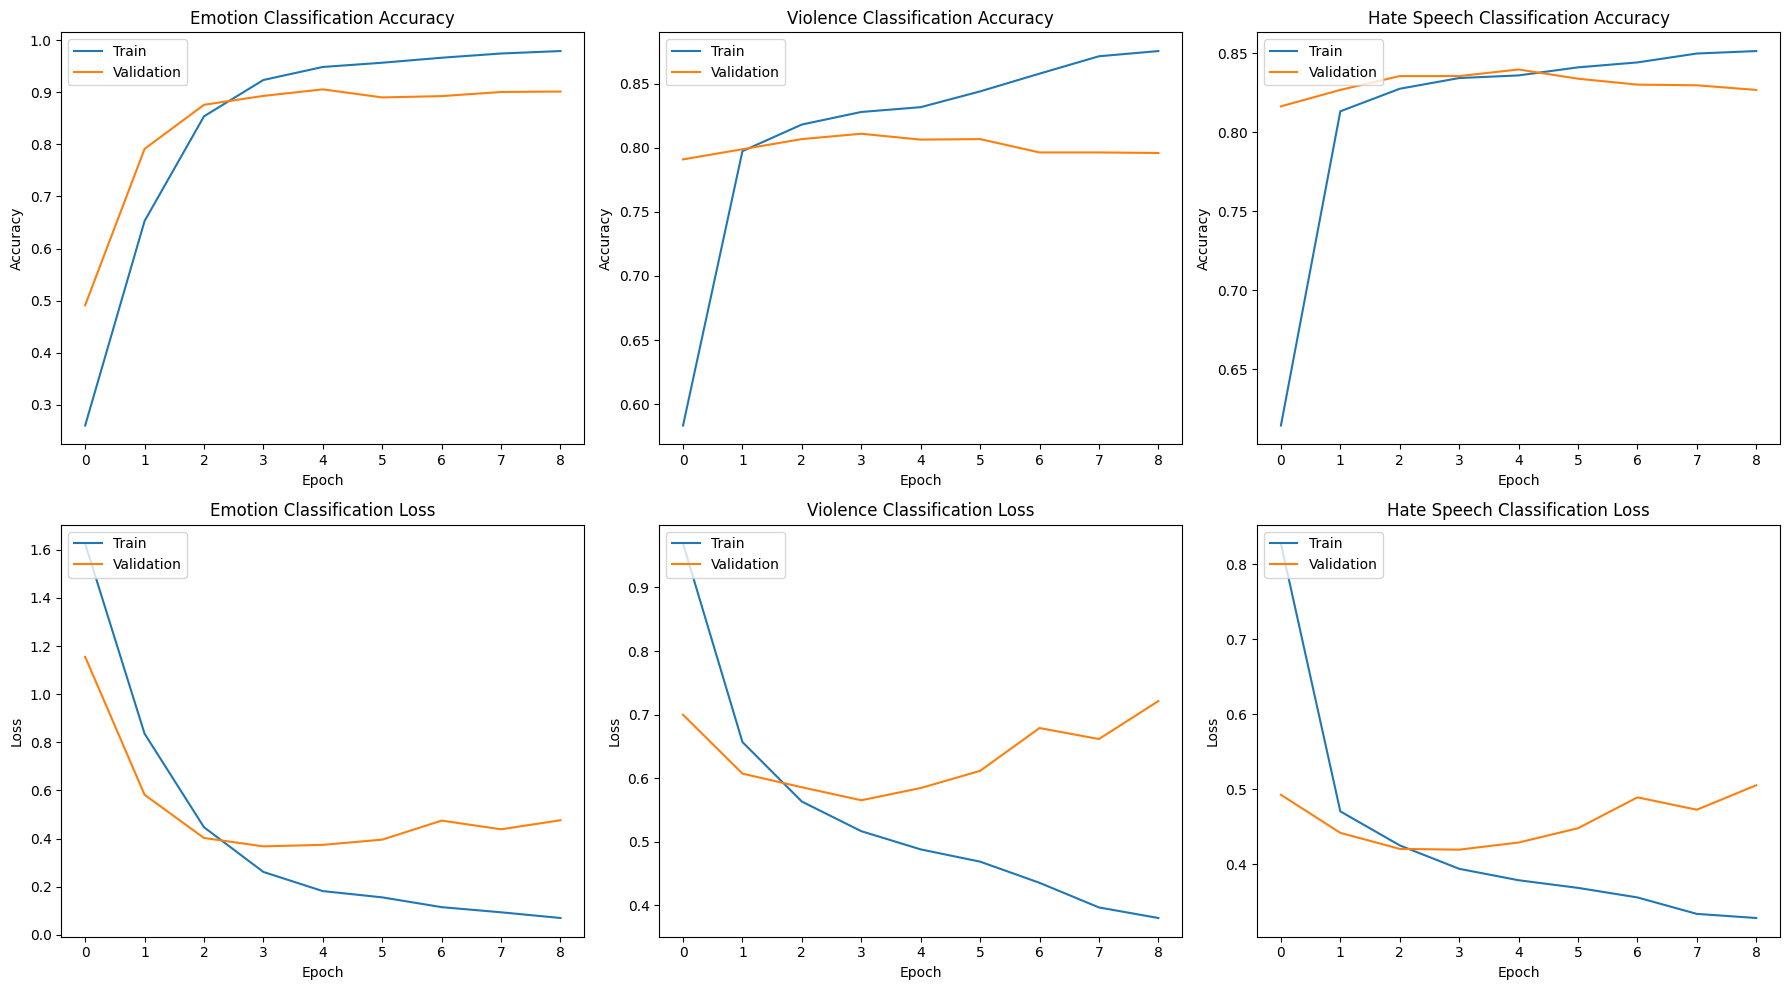

In [54]:
# Plot training history
def plot_training_history(history):
    """Plot the training and validation accuracy and loss for each task."""
    # Set up the figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot emotion task
    axes[0, 0].plot(history.history['emotion_output_accuracy'])
    axes[0, 0].plot(history.history['val_emotion_output_accuracy'])
    axes[0, 0].set_title('Emotion Classification Accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend(['Train', 'Validation'], loc='upper left')
    
    axes[1, 0].plot(history.history['emotion_output_loss'])
    axes[1, 0].plot(history.history['val_emotion_output_loss'])
    axes[1, 0].set_title('Emotion Classification Loss')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot violence task
    axes[0, 1].plot(history.history['violence_output_accuracy'])
    axes[0, 1].plot(history.history['val_violence_output_accuracy'])
    axes[0, 1].set_title('Violence Classification Accuracy')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(['Train', 'Validation'], loc='upper left')
    
    axes[1, 1].plot(history.history['violence_output_loss'])
    axes[1, 1].plot(history.history['val_violence_output_loss'])
    axes[1, 1].set_title('Violence Classification Loss')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot hate speech task
    axes[0, 2].plot(history.history['hate_output_accuracy'])
    axes[0, 2].plot(history.history['val_hate_output_accuracy'])
    axes[0, 2].set_title('Hate Speech Classification Accuracy')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].legend(['Train', 'Validation'], loc='upper left')
    
    axes[1, 2].plot(history.history['hate_output_loss'])
    axes[1, 2].plot(history.history['val_hate_output_loss'])
    axes[1, 2].set_title('Hate Speech Classification Loss')
    axes[1, 2].set_ylabel('Loss')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [55]:
# Evaluate model on validation sets
evaluation_results = model.evaluate(
    X_emotion_val_adjusted,
    {
        'emotion_output': y_emotion_val_adjusted,
        'violence_output': y_violence_val_adjusted,
        'hate_output': y_hate_val_adjusted
    }
)

# Print evaluation results
metrics_names = model.metrics_names
print("\nEvaluation Results:")
for i, metric in enumerate(metrics_names):
    print(f"{metric}: {evaluation_results[i]:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - emotion_output_accuracy: 0.8943 - emotion_output_loss: 0.3632 - hate_output_accuracy: 0.8453 - hate_output_loss: 0.4064 - loss: 1.3505 - violence_output_accuracy: 0.8040 - violence_output_loss: 0.5809

Evaluation Results:
loss: 1.3527
compile_metrics: 0.3679
emotion_output_loss: 0.5654
violence_output_loss: 0.4193
hate_output_loss: 0.8929


## 10. Making Predictions with the Model

Create a function to use our model for predicting emotions, violence, and hate speech in new text.

In [59]:
def visualize_confusion_matrices(model, X_val, y_true_dict):
    """
    Generate and visualize confusion matrices for each task in the multi-task model.
    
    Args:
        model: Trained multi-task model
        X_val: Validation data input
        y_true_dict: Dictionary containing true labels for each task
            (keys: 'emotion', 'violence', 'hate'; values: one-hot encoded labels)
    """
    # Get class labels for each task
    emotion_classes = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
    violence_classes = ['Harmful Traditional', 'Physical', 'Economic', 'Emotional', 'Sexual']
    hate_classes = ['Hate Speech', 'Offensive Speech', 'Neither']
    
    # Make predictions
    emotion_pred, violence_pred, hate_pred = model.predict(X_val)
    
    # Convert one-hot encoded true values to class indices
    y_emotion_true = np.argmax(y_true_dict['emotion_output'], axis=1)
    y_violence_true = np.argmax(y_true_dict['violence_output'], axis=1)
    y_hate_true = np.argmax(y_true_dict['hate_output'], axis=1)
    
    # Convert predictions to class indices
    y_emotion_pred = np.argmax(emotion_pred, axis=1)
    y_violence_pred = np.argmax(violence_pred, axis=1)
    y_hate_pred = np.argmax(hate_pred, axis=1)
    
    # Compute confusion matrices
    emotion_cm = confusion_matrix(y_emotion_true, y_emotion_pred)
    violence_cm = confusion_matrix(y_violence_true, y_violence_pred)
    hate_cm = confusion_matrix(y_hate_true, y_hate_pred)
    
    # Create a figure for visualizing the confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot emotion confusion matrix
    sns.heatmap(emotion_cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=emotion_classes, yticklabels=emotion_classes, ax=axes[0])
    axes[0].set_title('Emotion Classification')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Plot violence confusion matrix
    sns.heatmap(violence_cm, annot=True, fmt='d', cmap='Greens', cbar=False, 
                xticklabels=violence_classes, yticklabels=violence_classes, ax=axes[1])
    axes[1].set_title('Violence Classification')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    # Plot hate speech confusion matrix
    sns.heatmap(hate_cm, annot=True, fmt='d', cmap='Reds', cbar=False, 
                xticklabels=hate_classes, yticklabels=hate_classes, ax=axes[2])
    axes[2].set_title('Hate Speech Classification')
    axes[2].set_ylabel('True Label')
    axes[2].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print classification metrics for each task
    for task_name, y_true, y_pred, classes in [
        ('Emotion', y_emotion_true, y_emotion_pred, emotion_classes),
        ('Violence', y_violence_true, y_violence_pred, violence_classes),
        ('Hate Speech', y_hate_true, y_hate_pred, hate_classes)
    ]:
        accuracy = np.mean(y_true == y_pred)
        print(f"\n{task_name} Classification Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        
        # Per-class metrics
        print("\nPer-class metrics:")
        for i, class_name in enumerate(classes):
            true_pos = np.sum((y_true == i) & (y_pred == i))
            false_pos = np.sum((y_true != i) & (y_pred == i))
            false_neg = np.sum((y_true == i) & (y_pred != i))
            
            precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
            recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            print(f"{class_name}: Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step


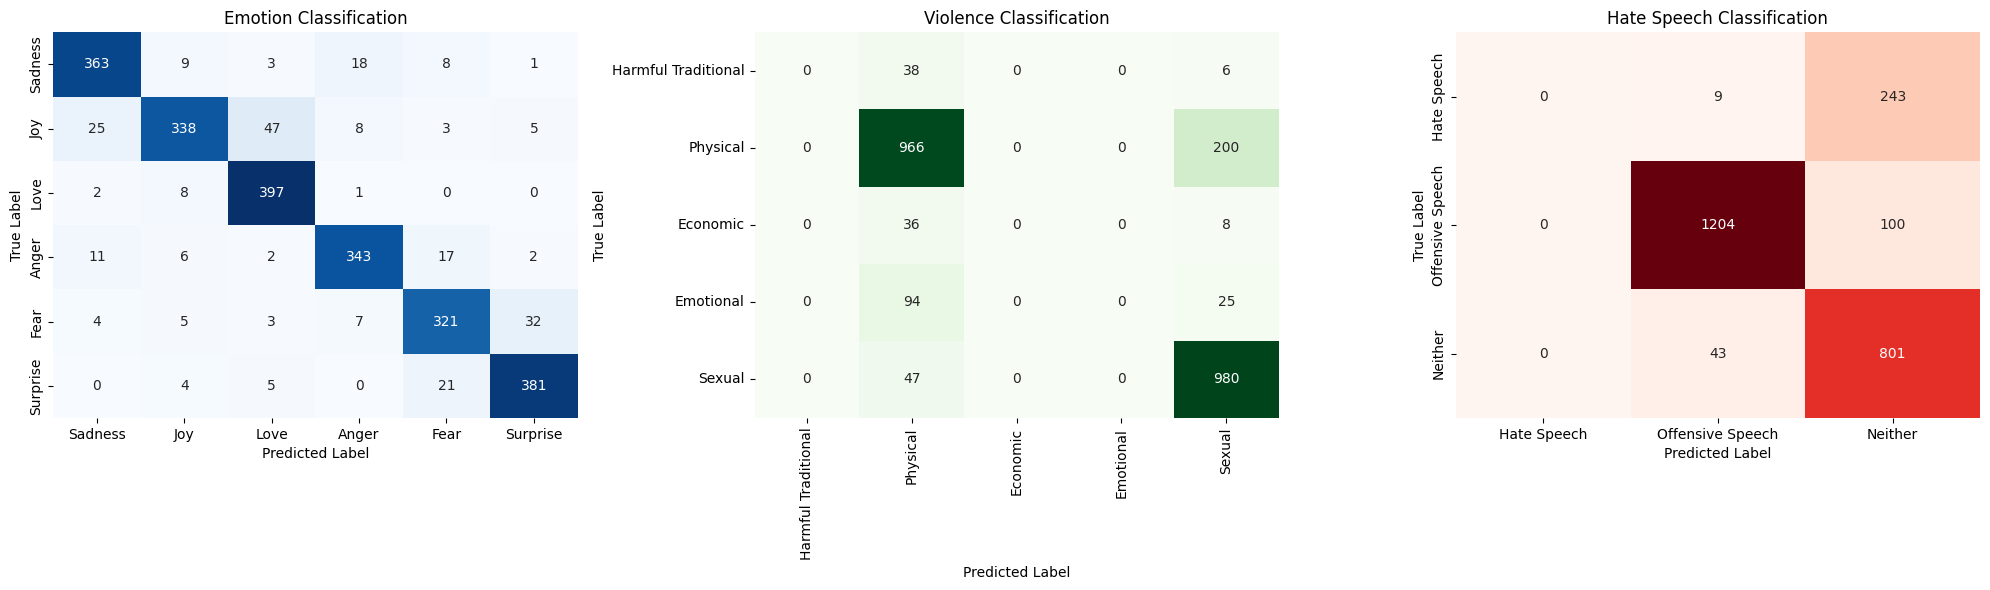


Emotion Classification Metrics:
Accuracy: 0.8929

Per-class metrics:
Sadness: Precision=0.8963, Recall=0.9030, F1-score=0.8996
Joy: Precision=0.9135, Recall=0.7934, F1-score=0.8492
Love: Precision=0.8687, Recall=0.9730, F1-score=0.9179
Anger: Precision=0.9098, Recall=0.9003, F1-score=0.9050
Fear: Precision=0.8676, Recall=0.8629, F1-score=0.8652
Surprise: Precision=0.9050, Recall=0.9270, F1-score=0.9159

Violence Classification Metrics:
Accuracy: 0.8108

Per-class metrics:
Harmful Traditional: Precision=0.0000, Recall=0.0000, F1-score=0.0000
Physical: Precision=0.8180, Recall=0.8285, F1-score=0.8232
Economic: Precision=0.0000, Recall=0.0000, F1-score=0.0000
Emotional: Precision=0.0000, Recall=0.0000, F1-score=0.0000
Sexual: Precision=0.8039, Recall=0.9542, F1-score=0.8727

Hate Speech Classification Metrics:
Accuracy: 0.8354

Per-class metrics:
Hate Speech: Precision=0.0000, Recall=0.0000, F1-score=0.0000
Offensive Speech: Precision=0.9586, Recall=0.9233, F1-score=0.9406
Neither: Preci

In [60]:
visualize_confusion_matrices (
    model,
    X_emotion_val_adjusted,
    {
        'emotion_output': y_emotion_val_adjusted,
        'violence_output': y_violence_val_adjusted,
        'hate_output': y_hate_val_adjusted
    }
    
)

In [56]:
def predict_text(text, model, tokenizer, max_length=MAX_SEQUENCE_LENGTH):
    """Make predictions for a given text across all three tasks.
    
    Args:
        text: Input text to classify
        model: Trained multi-task model
        tokenizer: Tokenizer used for processing text
        max_length: Maximum sequence length
        
    Returns:
        Dictionary of predictions for each task
    """
    # Clean the text using the same preprocessing function
    cleaned_text = clean_text(text)
    
    # Tokenize and pad the text
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)
    
    # Make predictions
    emotion_pred, violence_pred, hate_pred = model.predict(padded_sequence)
    
    # Get the class labels
    emotion_classes = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
    violence_classes = ['Harmful Traditional Practice', 'Physical Violence', 
                       'Economic Violence', 'Emotional Violence', 'Sexual Violence']
    hate_classes = ['Hate Speech', 'Offensive Speech', 'Neither']
    
    # Get the predicted class indices
    emotion_class_idx = np.argmax(emotion_pred[0])
    violence_class_idx = np.argmax(violence_pred[0])
    hate_class_idx = np.argmax(hate_pred[0])
    
    # Create a dictionary of results
    results = {
        'text': text,
        'cleaned_text': cleaned_text,
        'emotion': {
            'label': emotion_classes[emotion_class_idx],
            'confidence': float(emotion_pred[0][emotion_class_idx]),
            'all_probabilities': {emotion_classes[i]: float(emotion_pred[0][i]) 
                               for i in range(len(emotion_classes))}
        },
        'violence': {
            'label': violence_classes[violence_class_idx],
            'confidence': float(violence_pred[0][violence_class_idx]),
            'all_probabilities': {violence_classes[i]: float(violence_pred[0][i]) 
                               for i in range(len(violence_classes))}
        },
        'hate': {
            'label': hate_classes[hate_class_idx],
            'confidence': float(hate_pred[0][hate_class_idx]),
            'all_probabilities': {hate_classes[i]: float(hate_pred[0][i]) 
                              for i in range(len(hate_classes))}
        }
    }
    
    return results

In [57]:
# Test with some sample texts
sample_texts = [
    "I am so happy today, everything is going well!",
    "That movie was terrifying, I couldn't sleep afterwards.",
    "I can't believe how rude that person was to me.",
    "The news about the violence against women is heartbreaking.",
    "I love spending time with my family, they bring me joy."
]

# Make predictions using the emotion tokenizer for consistency
for text in sample_texts:
    results = predict_text(text, model, emotion_tokenizer)
    
    print(f"\nText: {results['text']}")
    print(f"Cleaned text: {results['cleaned_text']}")
    print(f"Emotion: {results['emotion']['label']} (confidence: {results['emotion']['confidence']:.2f})")
    print(f"Violence: {results['violence']['label']} (confidence: {results['violence']['confidence']:.2f})")
    print(f"Hate speech: {results['hate']['label']} (confidence: {results['hate']['confidence']:.2f})")
    print("-" * 80)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step

Text: I am so happy today, everything is going well!
Cleaned text: happy today everything going well
Emotion: Joy (confidence: 0.60)
Violence: Sexual Violence (confidence: 0.88)
Hate speech: Offensive Speech (confidence: 0.99)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Text: That movie was terrifying, I couldn't sleep afterwards.
Cleaned text: movie terrifying couldnt sleep afterwards
Emotion: Sadness (confidence: 0.76)
Violence: Sexual Violence (confidence: 0.83)
Hate speech: Offensive Speech (confidence: 0.91)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Text: I can't believe how rude that person was to me.
Cleaned text: cant believe rude person
Emotion: Anger (confidence: 0.97)
Violence: Physical Violence (confidence: 0.73)
Hate speech: Neither (confidence: 0.46)
-------------------------------

## 11. Save the Model

Save the trained model for future use.

In [ ]:
# Save the model
model.save('../models/multi_task_nlp_model.h5')
print("Model saved successfully.")

## 12. Conclusion

We've successfully built a multi-task LSTM model that can simultaneously detect emotions, violence, and hate speech in text. The model leverages shared layers to learn common text features, while having task-specific output layers for each classification task.

Key accomplishments:
- Preprocessed three different datasets for multi-task learning
- Built a multi-task LSTM architecture with shared and task-specific layers
- Trained the model to simultaneously predict emotions, violence, and hate speech
- Evaluated the model's performance across all three tasks
- Created a prediction function for new text inputs

Next steps could include:
- Fine-tuning the model architecture and hyperparameters
- Adding pre-trained word embeddings like GloVe or BERT for better performance
- Deploying the model as an API for real-time text analysis
- Creating a simple web interface for demonstrating the model's capabilities